In [1]:
import dask.array as da
from dask.diagnostics import ProgressBar

In [2]:
shape = (4000, 1000)
chunksize = (1000, 1000)
ones = da.ones(shape, chunks=chunksize)
ones

dask.array<wrapped, shape=(4000, 1000), dtype=float64, chunksize=(1000, 1000)>

In [3]:
ones.nbytes / 1e9

0.032

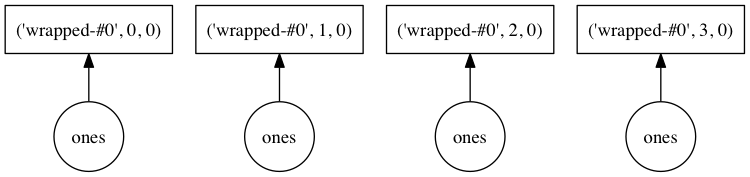

In [4]:
ones.visualize()

In [5]:
ones_sum = ones.sum()
ones_sum

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=()>

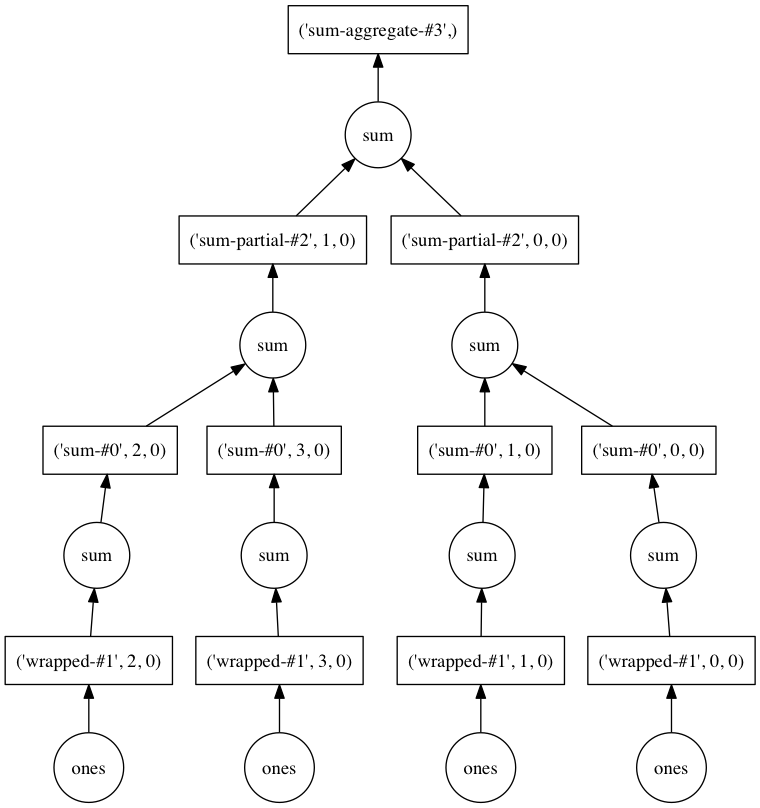

In [6]:
ones_sum.visualize()

In [7]:
ones_sum.compute()

4000000.0

In [8]:
complex_calc = ((1e-5 * ones + 1e-4)**2).sum()
complex_calc

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=()>

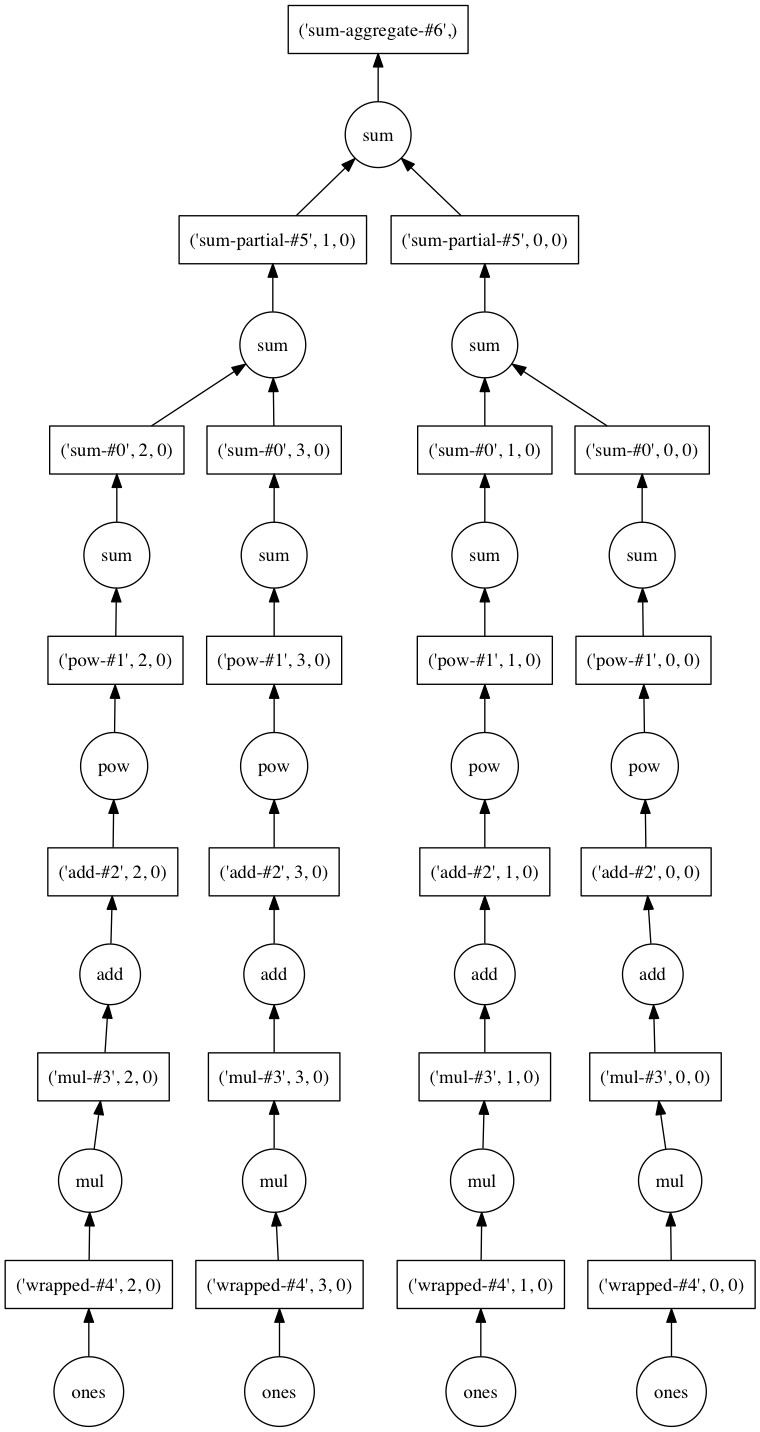

In [9]:
complex_calc.visualize()

In [10]:
random_array = da.random.normal(size=(2000, 2000), chunks=(1000, 1000))
random_array

dask.array<da.random.normal, shape=(2000, 2000), dtype=float64, chunksize=(1000, 1000)>

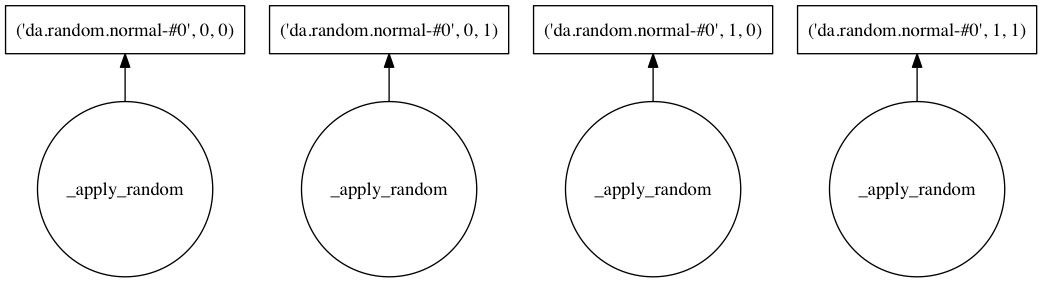

In [11]:
random_array.visualize()

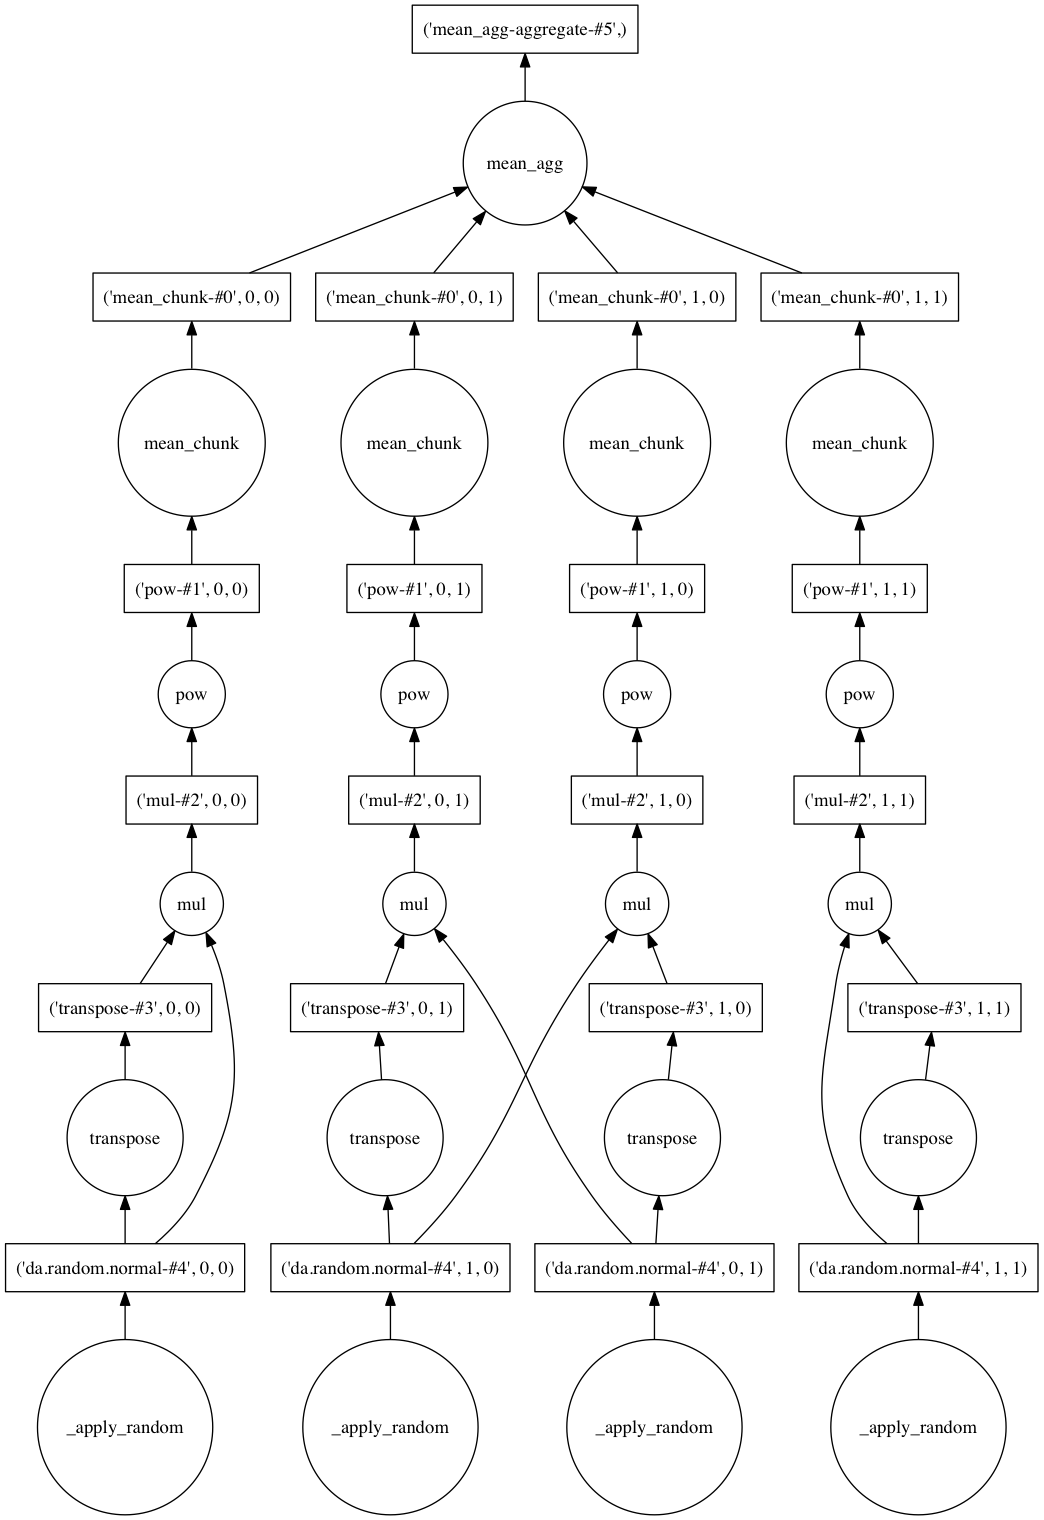

In [12]:
transpose_product_sq_mean = ((random_array * random_array.transpose())**2).mean()
transpose_product_sq_mean.visualize()

In [16]:
# same thing much bigger
random_array = da.random.normal(size=(40000, 40000), chunks=(1000, 1000))
transpose_product_sq_mean = ((random_array * random_array.transpose())**2).mean()
random_array.nbytes / 1e9
# don't try to visalize this!

12.8

In [17]:
with ProgressBar():
    transpose_product_sq_mean.compute()

In [14]:
from dask.distributed import Client

In [15]:
client = Client('tcp://129.236.20.45:8786')
client

Client Scheduler: tcp://129.236.20.45:8786 Dashboard: http://129.236.20.45:8787,Cluster Workers: 1 Cores: 16 Memory: 68.72 GB
